# Notebook examples for Chapter 7
# Supervised Classification Part 2
Continuing on the subject of supervised
classification, Chapter 7  begins with a discussion  of
post classification processing methods to
improve  results on the basis of contextual
information, after which  attention is turned to statistical
procedures for evaluating classification accuracy and for making
quantitative comparisons between different classifiers. 
As examples of  _ensembles_  of
classifiers, the _adaptive boosting_
technique is examined, applying it in particular to improve the generalization
accuracy of neural networks, and  the _random forest_ classifier, an ensemble of _binary  decision trees_ is also described. The remainder of the Chapter examines  more specialized forms of supervised image classification, namely as applied to   polarimetric SAR imagery, to data with  hyper-spectral resolution, and to   intermediate and high  resolution multispectral imagery using _convolutional neural networks_, _transfer learning_ and _semantic segmentation_.

In [2]:
import ee
ee.Authenticate()
ee.Initialize()
%matplotlib inline

## 7.1 Postprocessing
### 7.1.1 Majority filtering

### 7.1.2. Probabilistic label relaxation

In [10]:
%run scripts/classify -a 6 -p [1,2,3,4,5] -L [10,10] -e 100 -P imagery/AST_20070501_pca.tif imagery/train.shp

Training with Dnn(tensorflow)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 17.955318450927734
classifying...
row: 0
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 486us/step
row: 100
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 488us/step
row: 200
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 504us/step
row: 300
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 496us/step
row: 400
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 483us/step
row: 500
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 497us/step
row: 600
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 569us/step
row: 700
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 496us/step
row: 800
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 487us/step
row: 900
3125/3125 ━━━━━━━━━━━━━━━━━━━━ 2s 493us/step
elapsed time 15.947334051132202
class probabilities written to: imagery/AST_20070501_pca_classprobs.tif
thematic map written to: imagery/AST_20070501_pca_class.tif
74/74 ━━━━━━━━━━━━━━━━━━━━ 0s 511us/step
test results written to: im

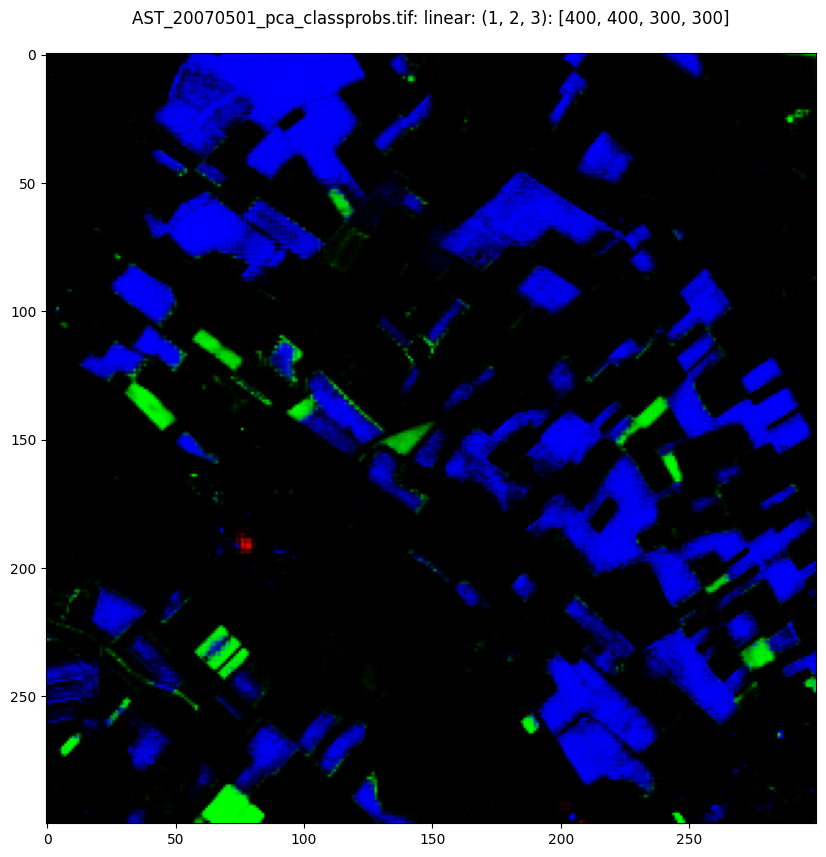

<Figure size 640x480 with 0 Axes>

In [15]:
%run scripts/dispms -f imagery/AST_20070501_pca_classprobs.tif -e 2 -p [1,2,3] -d [400,400,300,300]

In [12]:
run scripts/plr -i 3 imagery/AST_20070501_pca_classprobs.tif

       PLR
infile:  imagery/AST_20070501_pca_classprobs.tif
iterations:  3
estimating compatibility matrix...
label relaxation...
iteration 1
iteration 2
iteration 3
result written to: imagery/AST_20070501_pca_classprobs_plr.tif
elapsed time: 45.00696516036987
--done------------------------


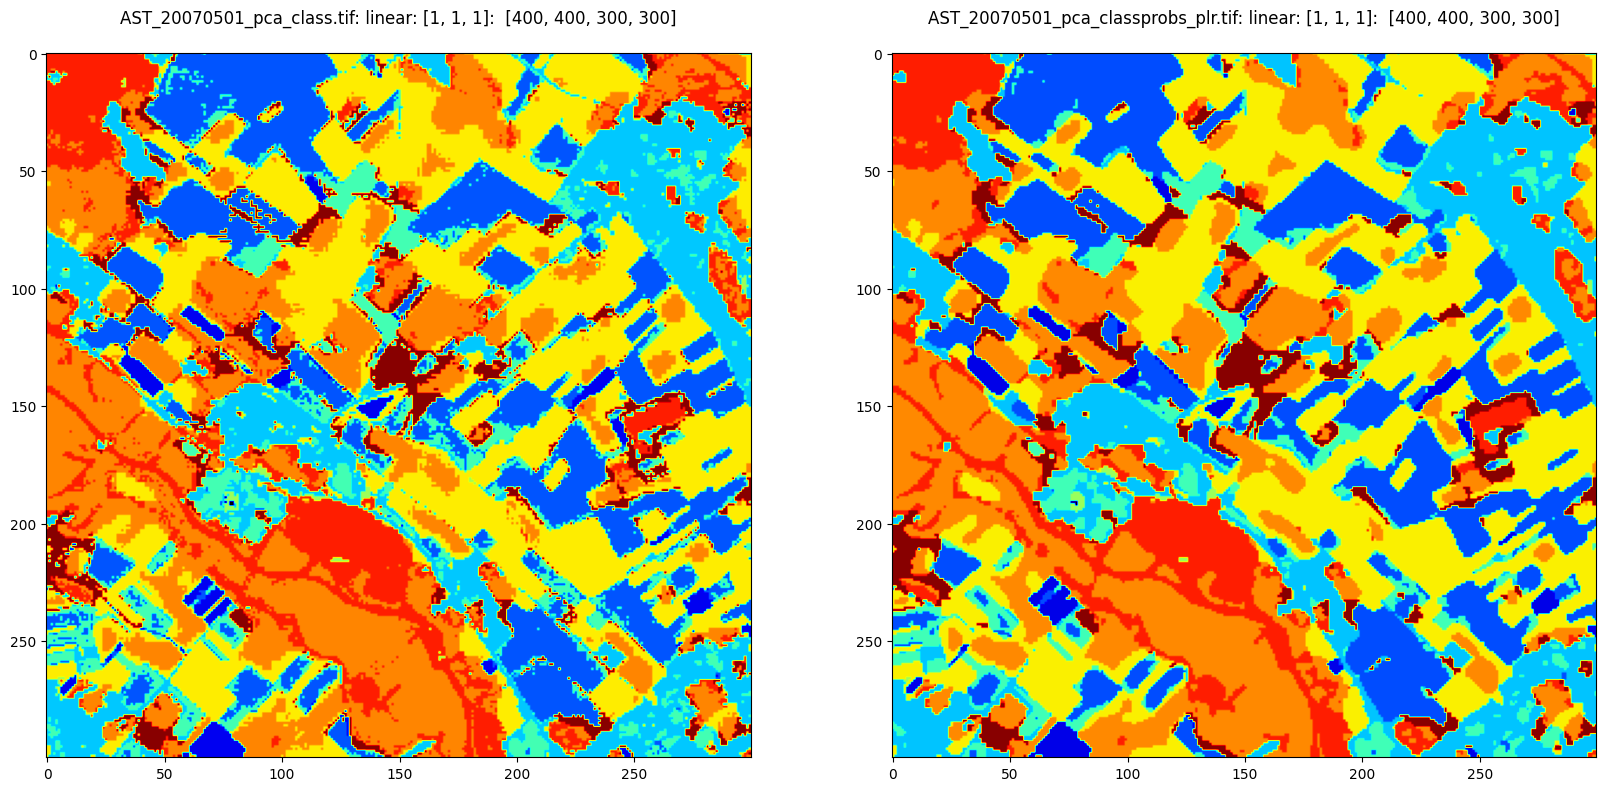

<Figure size 640x480 with 0 Axes>

In [13]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c -d [400,400,300,300] \
-F imagery/AST_20070501_pca_classprobs_plr.tif -C -D [400,400,300,300] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter7/fig7_1.eps'

## 7.2 Evaluation and comparison of classification accuracy

### 7.2.1 Accuracy assessment

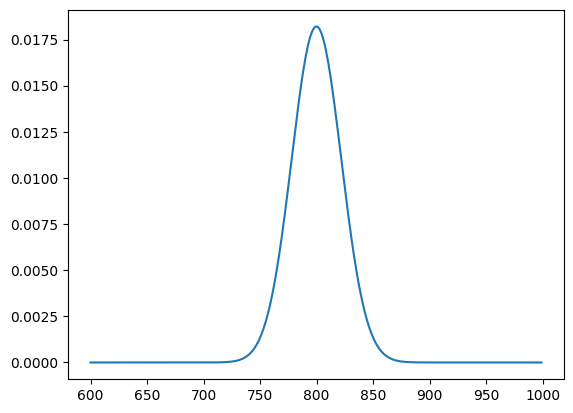

In [5]:
import numpy as np
from scipy.stats import binom
import matplotlib.pyplot as plt

theta = 0.4
n = 2000
x = np.arange(600, 1000)
# pmf = probability mass function
plt.plot(x, binom.pmf(x, n, theta))

#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_2.eps')

In [6]:
run scripts/ct imagery/AST_20070501_pca_NNet(Congrad).tst

classification statistics
NNet(Congrad)test results for imagery/AST_20070501_pca.tif 
Tue Jun 24 15:20:03 2025
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: imagery/AST_20070501_pca_classprobs.tif 

Misclassification rate: 0.035533
Standard deviation: 0.003807
Conf. interval (95 percent): [0.028792 , 0.043781]
Kappa coefficient: 0.959892
Standard deviation: 0.004300
Contingency Table
[[ 181.       0.       0.       0.       0.       0.       0.       0.       0.       0.     181.       1.   ]
 [   0.     147.       0.       0.       0.       0.       0.       0.       0.       0.     147.       1.   ]
 [   0.       0.     227.       0.       1.       0.       0.       0.       0.       0.     228.       0.996]
 [   0.       0.       0.     324.       9.       2.       0.       1.       0.       0.     336.       0.964]
 [   0.       1.       1.      11.     213.       0.       0.       0.       0.       0.     226.       0.942]
 [   0.       0.   

### 7.2.2 Accuracy assessment on the GEE

In [7]:
import ee
ee.Initialize()
# first 4 principal components of ASTER image
image = ee.Image('projects/ee-mortcanty/assets/CRC5/AST_20070501_pca') \
                                      .select(0,1,2,3)
# training data
table = ee.FeatureCollection('projects/ee-mortcanty/assets/CRC5/train')
# sample the image with the polygons to a feature  
# collection, rename the class id columns from strings 
# to integers, add a column of random numbers in [0,1]
trainTestData = image.sampleRegions(collection=table,
                                properties=['CLASS_ID'],
                                scale=15) \
 .remap(list(map(str,range(10))),list(range(10)),
                                           'CLASS_ID') \
 .randomColumn('rand',seed=12345) 
# filter on the random column to split into training and
# test feature collections in the ration of 2:1
trainData = trainTestData.filter(ee.Filter.lt('rand',0.67))
testData = trainTestData.filter(ee.Filter.gte('rand',0.67))
print('train pixels: %i'%trainData.size().getInfo())
print('test pixels:  %i'%testData.size().getInfo())
# train a (default) SVM classifier on training data   
classifier = ee.Classifier.libsvm()
trained = classifier.train(trainData,'CLASS_ID',
                                   image.bandNames()) 
# test the trained classifier with the test data
tested = testData.classify(trained)
# generate a confusion matrix with the 
# classified test data
cm = tested.errorMatrix('CLASS_ID','classification')
# and from it determine the accuracy and kappa 
print('accuracy: %f'%cm.accuracy().getInfo())
print('kappa:    %f'%cm.kappa().getInfo())

train pixels: 4801
test pixels:  2372
accuracy: 0.946880
kappa:    0.939896


### 7.2.3 Crossvalidation on parallel architectures

In [8]:
!ipcluster start -n 4 --daemonize

2025-06-24 15:34:10.308 [IPClusterStart] CRITICAL | Cluster is already running at /home/mort/.ipython/profile_default/security/cluster-.json. use `ipcluster stop` to stop the cluster.


In [9]:
run scripts/crossvalidate -p [1,2,3,4,5] -a 6 -L [10,10] -e 100 imagery/AST_20070501_pca.tif imagery/train.shp

10-fold cross validation, algorithm: Dnn(Tensorflow)
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


7162 training pixel vectors were read in
attempting parallel calculation ...
available engines [0, 1, 2, 3]
execution time: 109.2279942035675
misclassification rate: 0.047751
standard deviation:     0.005676


### 7.2.4 Model comparison

In [ ]:
run scripts/classify -p [1,2,3,4,5] -a 6 -L [10,10] -e 500 imagery/AST_20070501_pca.tif imagery/train.shp

In [ ]:
run scripts/classify -p [1,2,3,4,5] -a 7 imagery/AST_20070501_pca.tif imagery/train.shp

In [10]:
%run scripts/mcnemar imagery/AST_20070501_pca_SVM.tst \
imagery/AST_20070501_pca_Dnn(tensorflow).tst 

     McNemar test
first classifier:
SVMtest results for imagery/AST_20070501_pca.tif 
Tue Jun 24 15:26:59 2025
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: imagery/AST_20070501_pca_classprobs.tif 

second classifier:
Dnn(tensorflow)test results for imagery/AST_20070501_pca.tif 
Tue Jun 24 15:30:00 2025
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: imagery/AST_20070501_pca_classprobs.tif 

test observations: 2364
classes: 10
first classifier: 95
second classifier: 110
McNemar statistic: 1.097561
P-value: 0.294802


In [12]:
run scripts/classify -p [1,2,3,4,5] -a 2  imagery/AST_20070501_pca.tif imagery/train.shp

Training with Gausskernel
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']


/home/mort/python/CRC5Docker/src/auxil/supervisedclass.py:98: RuntimeWarning: invalid value encountered in divide
  return pvs/s


sigma: 0.001000  error: 0.355773
sigma: 0.100000  error: 0.050646
sigma: 1.000000  error: 0.197791
sigma: 0.443769  error: 0.134639
sigma: 0.231308  error: 0.101917
sigma: 0.150155  error: 0.074823
sigma: 0.062185  error: 0.039183
sigma: 0.038815  error: 0.032097
sigma: 0.024371  error: 0.028345
sigma: 0.015444  error: 0.029596
sigma: 0.024002  error: 0.028137
sigma: 0.020758  error: 0.028345
sigma: 0.022763  error: 0.027928
sigma: 0.022657  error: 0.027928
sigma: 0.022710  error: 0.027928
sigma: 0.022687  error: 0.027928
elapsed time 20.15547204017639
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 365.4442629814148
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_Gausskernel.tst
done


In [13]:
%run scripts/mcnemar imagery/AST_20070501_pca_Gausskernel.tst \
imagery/AST_20070501_pca_Dnn(tensorflow).tst

     McNemar test
first classifier:
Gausskerneltest results for imagery/AST_20070501_pca.tif 
Tue Jun 24 15:46:28 2025
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: None 

second classifier:
Dnn(tensorflow)test results for imagery/AST_20070501_pca.tif 
Tue Jun 24 15:30:00 2025
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: imagery/AST_20070501_pca_classprobs.tif 

test observations: 2364
classes: 10
first classifier: 47
second classifier: 112
McNemar statistic: 26.572327
P-value: 0.000000


## 7.3 Ensembles
### 7.3.1 Adaptive boosting

Training with ADABOOST.M1 and 5 epochs per ffn
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


running instance: 1  trial: 1
train error: 0.035223 test error: 0.041032
running instance: 2  trial: 1
train error: 0.031680 test error: 0.039763
running instance: 3  trial: 1
train error: 0.031263 test error: 0.038917
running instance: 4  trial: 1
train error: 0.031263 test error: 0.038917
running instance: 5  trial: 1
train error: 0.030638 test error: 0.039763
running instance: 6  trial: 1
train error: 0.029179 test error: 0.037225
running instance: 7  trial: 1
train error: 0.028970 test error: 0.037648
running instance: 8  trial: 1
train error: 0.028345 test error: 0.038071
running instance: 9  trial: 1
train error: 0.028762 test error: 0.036802
running instance: 10  trial: 1
train error: 0.027928 test error: 0.036802
running instance: 11  trial: 1
train error: 0.028345 test error: 0.037225
running instance: 12  trial: 1
running instance: 12  trial: 2
running instance: 12  trial: 3
train error: 0.027928 test error: 0.036802
running instance: 13  trial: 1
train error: 0.027928 test e

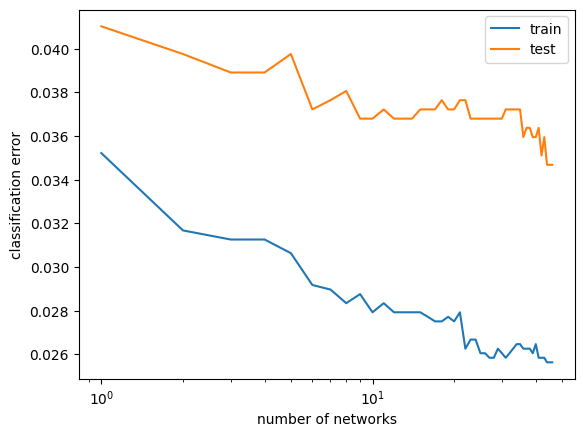

classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
thematic map written to: imagery/AST_20070501_pca_class.tif
elapsed time 16.38192582130432


In [14]:
run scripts/adaboost -p [1,2,3,4,5]  -L 10 -n 50 imagery/AST_20070501_pca.tif  imagery/train.shp

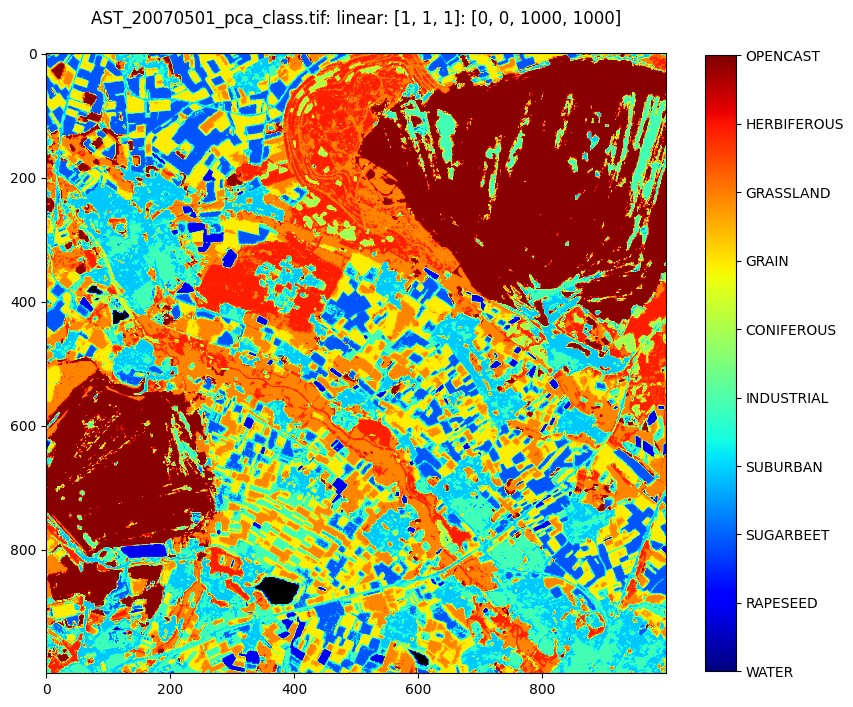

In [15]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']" \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter7/fig7_x.eps'

### 7.3.2 Binary decision trees and random forests

In [16]:
run scripts/classify -p [1,2,3,4,5] -a 8  imagery/AST_20070501_pca.tif imagery/train.shp

Training with RF
reading training data...


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


training on 4798 pixel vectors...
classes: ['WASSER [BL', 'RAPS [YELL', 'RUEBEN [CY', 'SIEDLUNG [', 'GEWERBE [M', 'NADELWALD', 'GETREIDE [', 'GRAS [RED2', 'LAUBWALD [', 'TAGEBAU [W']
elapsed time 2.009429931640625
classifying...
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
elapsed time 21.8486967086792
thematic map written to: imagery/AST_20070501_pca_class.tif
test results written to: imagery/AST_20070501_pca_RF.tst
done


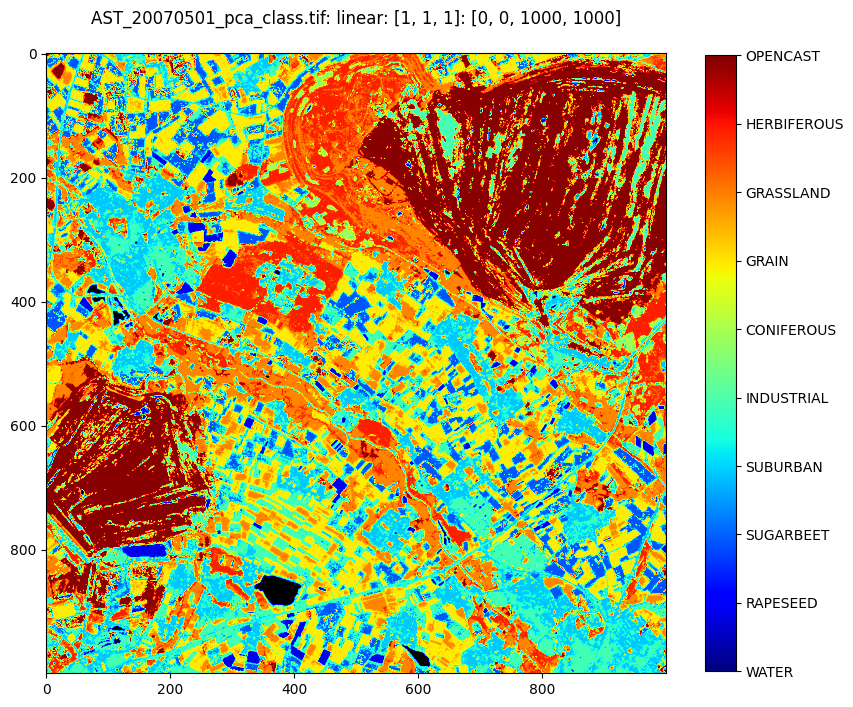

In [17]:
%run scripts/dispms -f imagery/AST_20070501_pca_class.tif -c \
-r  "['WATER', 'RAPESEED', 'SUGARBEET', 'SUBURBAN', 'INDUSTRIAL', 'CONIFEROUS', 'GRAIN', 'GRASSLAND', 'HERBIFEROUS', 'OPENCAST']"

In [18]:
%run scripts/mcnemar imagery/AST_20070501_pca_Gausskernel.tst \
imagery/AST_20070501_pca_RF.tst

     McNemar test
first classifier:
Gausskerneltest results for imagery/AST_20070501_pca.tif 
Tue Jun 24 15:46:28 2025
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: None 

second classifier:
RFtest results for imagery/AST_20070501_pca.tif 
Tue Jun 24 16:14:50 2025
Classification image: imagery/AST_20070501_pca_class.tif 
Class probabilities image: None 

test observations: 2364
classes: 10
first classifier: 50
second classifier: 67
McNemar statistic: 2.470085
P-value: 0.116032


## 7.4 Classification of polarimetric SAR imagery

## 7.5 Hyperspectral image analysis
### 7.5.1 Spectral mixture modeling
### 7.5.2 Unconstrained linear unmixing

In [20]:
from osgeo import gdal
from osgeo.gdalconst import GA_ReadOnly
import numpy as np
import matplotlib.pyplot as plt

inDataset = gdal.Open('imagery/97_radianz_registriert_voll',GA_ReadOnly)                       
cols = inDataset.RasterXSize
rows = inDataset.RasterYSize    
bands = inDataset.RasterCount
print(rows, cols, bands)

512 614 224


ERROR 1: Maximum number of characters allowed reached.


In [21]:
Im = np.zeros((rows,cols,bands)) 
for b in range(bands):
    band = inDataset.GetRasterBand(b+1)
    Im[:,:,b] = band.ReadAsArray(0,0,cols,rows)  

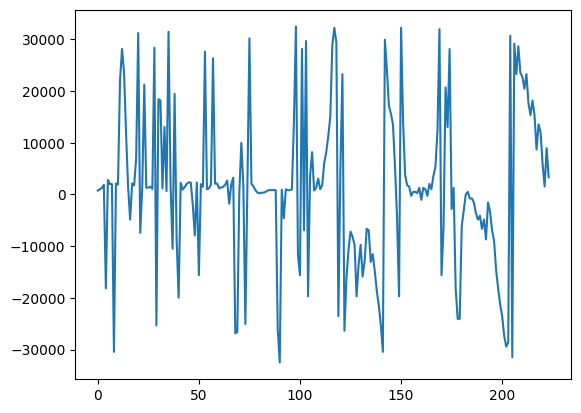

In [22]:
# spectral cut
plt.plot(Im[300,300,:])
#plt.savefig('/home/mort/LaTeX/new projects/CRC4/Chapter7/fig7_6.eps',bbox_inches='tight')

### 7.5.3 Intrinsic end-members and pixel purity

------------MNF ---------------
Tue Jun 24 16:18:36 2025
Input imagery/97_radianz_registriert_voll


ERROR 1: Maximum number of characters allowed reached.


Signal to noise ratios: [8.176397   5.2275453  4.3195086  2.9181838  2.5331788  2.2690113
 2.195611   2.0360427  1.7489603  1.7093334  1.6091063  1.5357301
 1.3793161  1.2976725  1.2197104  1.1656473  1.109391   1.0812812
 1.0492995  1.0363803  0.9592868  0.8728442  0.84626555 0.83644605
 0.80188596 0.7913779  0.75585747 0.74410915 0.73713434 0.69875026
 0.68781054 0.6800947  0.6698389  0.64265275 0.63974833 0.63259935
 0.62931275 0.6187433  0.6155267  0.6120652  0.6062727  0.5949068
 0.5930885  0.5872364  0.58242977 0.5785725  0.575614   0.57014716
 0.569322   0.5627202  0.55612826 0.5542084  0.5493144  0.54553616
 0.5439917  0.5419792  0.54117393 0.5379422  0.5349852  0.52995193
 0.5218158  0.519151   0.51607347 0.51372373 0.5118644  0.50964975
 0.50605047 0.5009295  0.4989127  0.49580038 0.49361134 0.4916891
 0.49010277 0.4873197  0.4858873  0.48411143 0.48317504 0.4807427
 0.47730327 0.4760946  0.4709202  0.46978903 0.46692216 0.46574378
 0.46271026 0.45855892 0.4543023  0.45317924

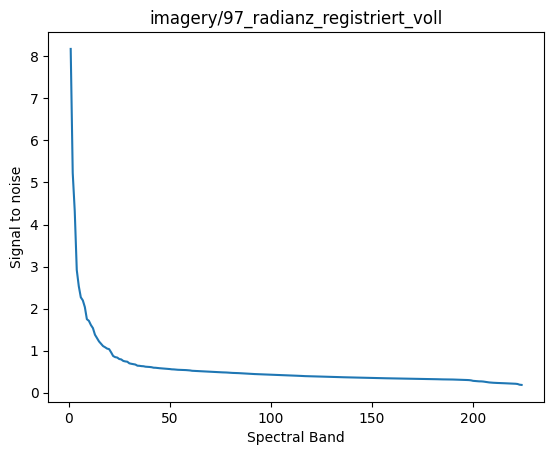

MNFs written to: imagery/97_radianz_registriert_voll_mnf
elapsed time: 7.228949069976807


In [23]:
run scripts/mnf.py imagery/97_radianz_registriert_voll

### 7.5.4 Anomaly detection: The RX algorithm

In [24]:
run scripts/rx imagery/AST_20070501_pca.tif

------------ RX ---------------
Tue Jun 24 16:19:22 2025
Input imagery/AST_20070501_pca.tif


Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.
Warning 1: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


Result written to imagery/AST_20070501_pca_rx.tif
elapsed time: 0.2517111301422119


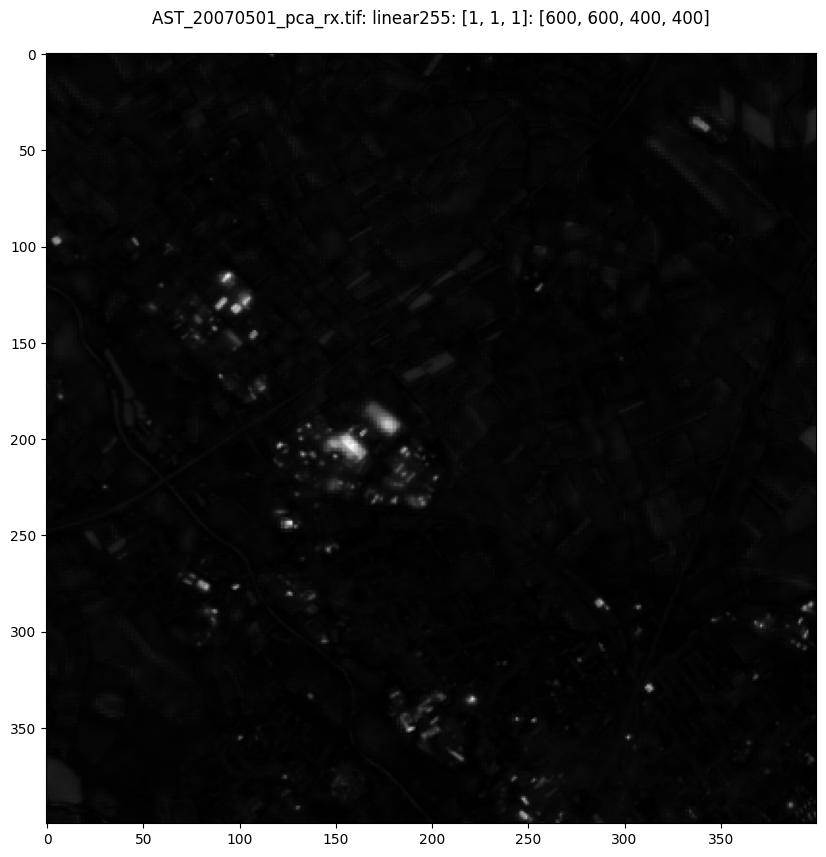

In [25]:
run scripts/dispms -f imagery/AST_20070501_pca_rx.tif -e 1 -d [600,600,400,400]

### 7.5.5 Anomaly detection: The kernel RX algorithm

In [27]:
run scripts/krx -s 2000 imagery/AST_20070501_pca.tif

Warning 1: imagery/AST_20070501_pca.tif: TIFFReadDirectory:Sum of Photometric type-related color channels and ExtraSamples doesn't match SamplesPerPixel. Defining non-color channels as ExtraSamples.


------------ KRX ---------------
Tue Jun 24 16:22:55 2025
Input imagery/AST_20070501_pca.tif
GMA: 0.000000
row: 0
row: 100
row: 200
row: 300
row: 400
row: 500
row: 600
row: 700
row: 800
row: 900
Result written to imagery/AST_20070501_pca_krx.tif
elapsed time: 114.83920431137085


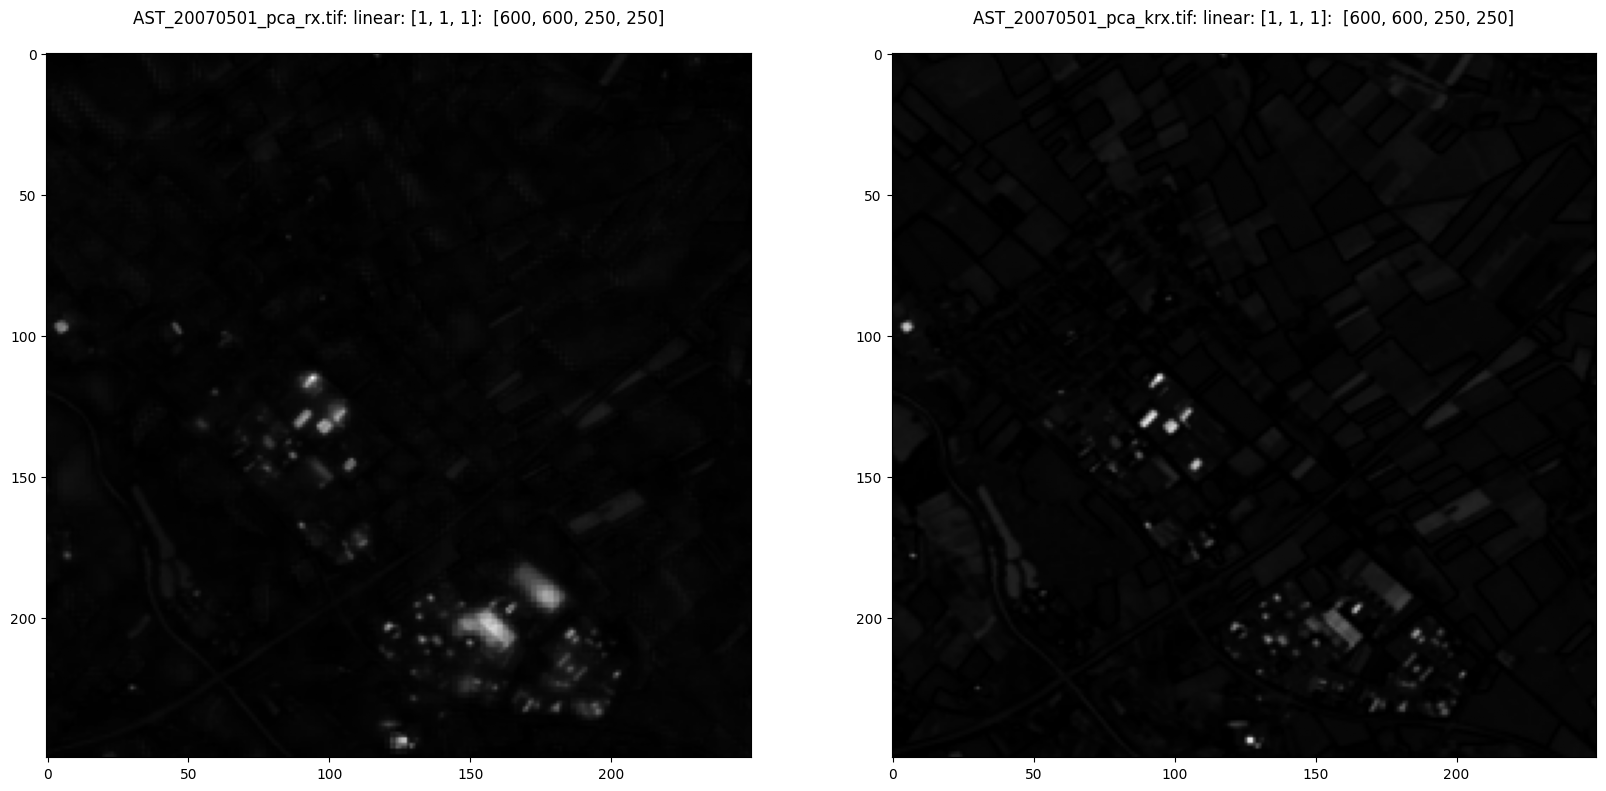

In [28]:
%run scripts/dispms -f imagery/AST_20070501_pca_rx.tif -e 2 -d [600,600,250,250] \
-F imagery/AST_20070501_pca_krx.tif -E 2 -D [600,600,250,250] \
#-s '/home/mort/LaTeX/new projects/CRC5/Chapter7/fig7_9.eps'

## 7.6 Convolutional neural networks

### 7.6.1 Transfer learning

The examples in the text can be run on Google Colab with a GPU runtime. Use this link:

https://colab.research.google.com/drive/1aleipk9k16e5jAjR1FqcOl9NB7FUjLng

### 7.6.2 Semantic segmentation

These examples should be run on Google Colab with a GPU runtime. Use this link:

https://colab.research.google.com/drive/136YAVBZCwppz2SU-6Yxo1q2D2geyq0se